In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pandas as pd

In [15]:
def exp_model(x, a, b, lambda_):
    return a - b*np.exp(-lambda_*x)

In [16]:
# Initialize the random number generator
np.random.seed(24)

# Define the parameters
a = 0.8
b = 0.6
lambda_ = 0.1
scale_param = 40

# Generate dummy student data 
dataset = pd.DataFrame({'student_id': [], 'attempt': [], 'proba': []})
max_attempt = (np.rint(np.random.exponential(scale_param,1000))).astype(int) # We saw that the number of attempts per student is exponentially distributed
for i in range(len(max_attempt)):
    student_id = np.repeat(i, max_attempt[i]) 
    attempt = np.arange(max_attempt[i])
    e = np.random.randn(max_attempt[i])*(np.random.randn()*0.1 + 0.1) # Generate some noise with a different variance for each student
    proba = exp_model(attempt, a, b, lambda_) + e # Generate the probability of success for each attempt
    
    dataset = pd.concat([dataset, pd.DataFrame({'student_id': student_id, 'attempt': attempt, 'proba': proba})], ignore_index=True)
    
dataset
    


,student_id,attempt,proba
0,0.0,0.0,0.033182
1,0.0,1.0,0.432661
2,0.0,2.0,0.192583
3,0.0,3.0,0.199179
4,0.0,4.0,0.523653
...,...,...,...
42647,999.0,0.0,-0.082514
42648,999.0,1.0,0.297944
42649,999.0,2.0,0.510794
42650,999.0,3.0,0.258053


In [17]:
def exp_fit(x):
    param_pred, cov_pred = scipy.optimize.curve_fit(lambda t,a,b,lambda_: a-b*np.exp(-lambda_*t),  x.attempt,  x.proba, bounds=([0,-1,0], [1, 1, np.inf]))
    a, b, lambda_ = param_pred
    return pd.Series([a, b, lambda_], index=['a', 'b', 'lambda_'])

/Users/emmaboehly/programmation/anaconda3/envs/MLBD/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


parameters for the exponential fit for each student


,a,b,lambda_,number_attempts
student_id,,,,
0.0,0.819088,0.661270,0.085856,129
1.0,0.827397,0.666630,0.132737,48
2.0,0.791876,0.641846,0.102261,357
3.0,0.888909,0.662349,0.073369,10
4.0,0.638914,0.477710,0.292600,18
...,...,...,...,...
995.0,0.320515,0.181464,17.830696,3
996.0,0.878971,0.683562,0.084590,31
997.0,0.435180,0.448483,0.609687,16


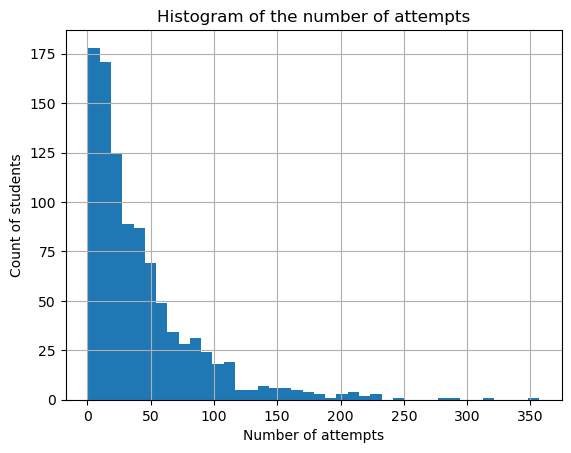

In [18]:
# Compute the parameters for the exponential fit for each student
students_param = dataset.groupby('student_id').apply(lambda x: exp_fit(x))
students_param['number_attempts'] = dataset.groupby('student_id').size()
print('parameters for the exponential fit for each student')
display(students_param)

# Plot the histogram of the number of attempts
students_param.number_attempts.hist(bins=40)
plt.title('Histogram of the number of attempts')
plt.xlabel('Number of attempts')
plt.ylabel('Count of students')
plt.show()

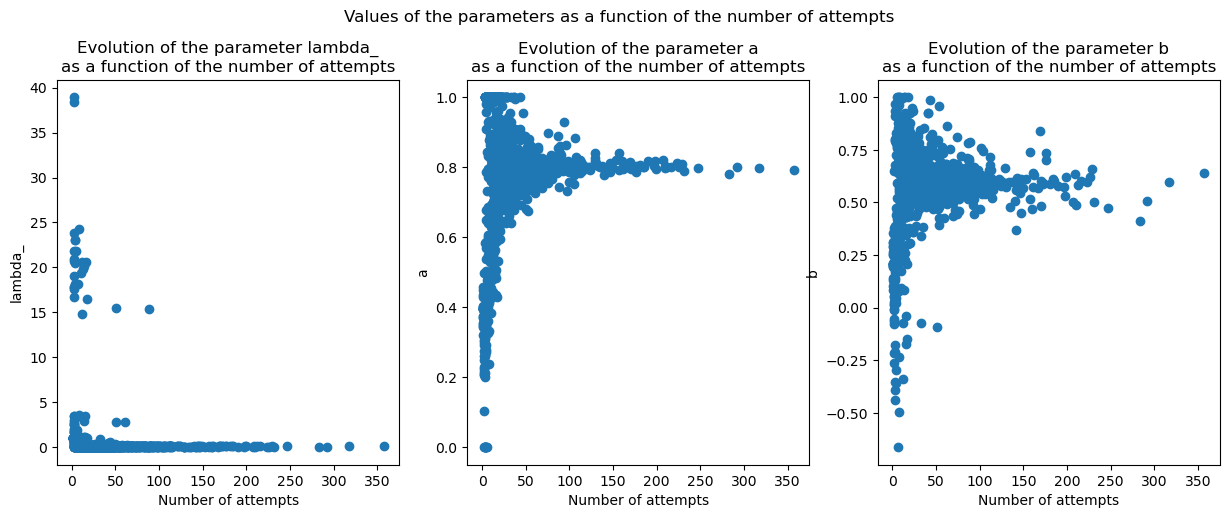

There is 229 students with more than 60 attempts which corresponds to 23.34 % of the students


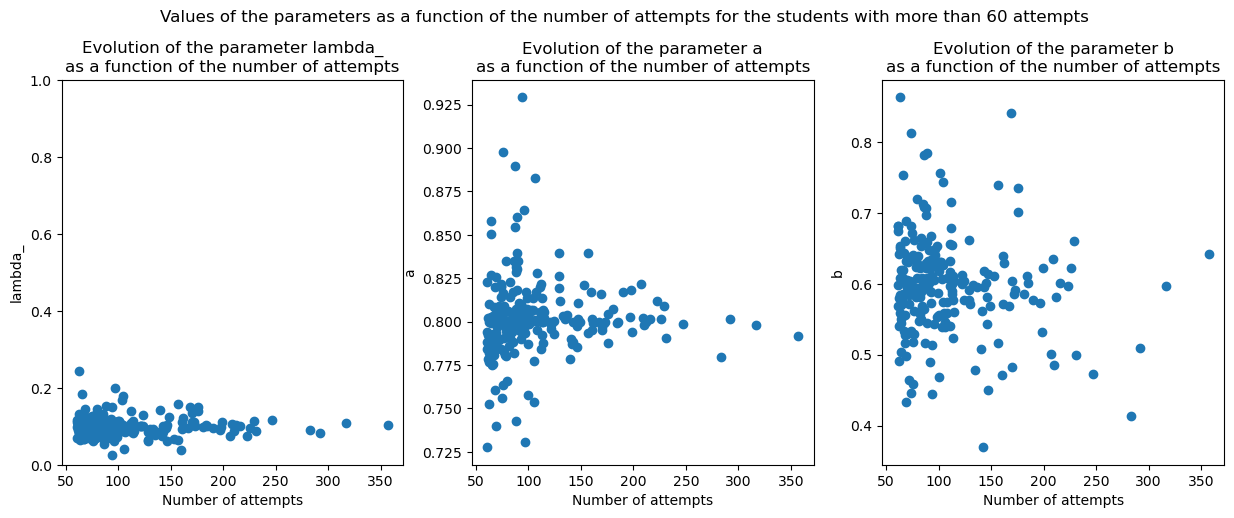

In [19]:
# Plot the values of each parameter as a function of the number of attempts
parameters = ['lambda_', 'a', 'b']

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
for i in range(len(parameters)):
    ax[i].plot(students_param['number_attempts'], students_param[parameters[i]], 'o')
    ax[i].set_xlabel('Number of attempts')
    ax[i].set_ylabel(parameters[i])
    ax[i].set_title('Evolution of the parameter ' + parameters[i] + '\nas a function of the number of attempts')
plt.suptitle('Values of the parameters as a function of the number of attempts', y=1.02)
plt.show()

# Keep only the students that played the most, i.e. that are more likely to have reached their maximum performance
master_param = students_param[students_param['number_attempts'] > scale_param*1.5]
print('There is', master_param.shape[0], 'students with more than', int(scale_param*1.5), 'attempts which corresponds to', round(master_param.shape[0]/students_param.shape[0]*100, 2), '% of the students')

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
for i in range(len(parameters)):
    ax[i].plot(master_param['number_attempts'], master_param[parameters[i]], 'o')
    ax[i].set_xlabel('Number of attempts')
    ax[i].set_ylabel(parameters[i])
    ax[i].set_title('Evolution of the parameter ' + parameters[i] + '\nas a function of the number of attempts')
ax[0].set_ylim(0, 1)
plt.suptitle(f'Values of the parameters as a function of the number of attempts for the students with more than ' + str(int(scale_param*1.5)) + ' attempts', y=1.02)
plt.show()


In [20]:
# Extract the median value of each parameter
a_pred, b_pred, lambda_pred,_ = master_param.median()
print('The median values of the parameters are:')
print('a =', a_pred)
print('b =', b_pred)
print('lambda =', lambda_pred)

The median values of the parameters are:
a = 0.8005224567092543
b = 0.5982945329956425
lambda = 0.09946797502270174


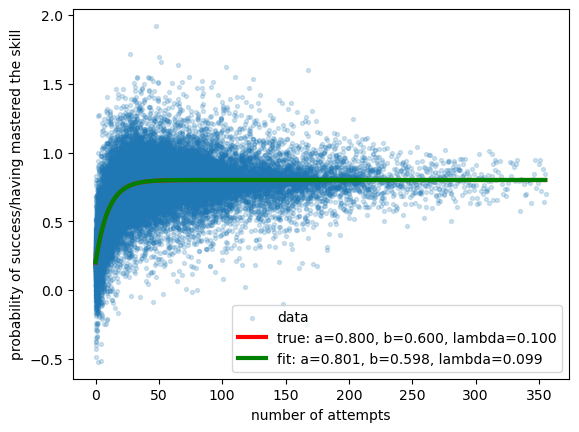

In [21]:
rx = np.arange(max(dataset.attempt))

plt.scatter(dataset.attempt, dataset.proba, label='data', alpha=0.2, s=8)
plt.plot(rx, exp_model(rx, a, b, lambda_), label='true: a=%5.3f, b=%5.3f, lambda=%5.3f' % tuple([a,b,lambda_]), color='red', linewidth=3)
plt.plot(rx, exp_model(rx, a_pred, b_pred, lambda_pred), label='fit: a=%5.3f, b=%5.3f, lambda=%5.3f' % tuple([a_pred, b_pred, lambda_pred]), color='green', linewidth=3)
plt.xlabel('number of attempts')
plt.ylabel('probability of success/having mastered the skill')
plt.legend()
plt.show()

In [22]:
# Generate data for new students (we already computed the probability of success for the last attempt)
np.random.seed(24)
last_attempt = np.random.exponential(scale_param, 800).astype(int)
last_proba = exp_model(last_attempt, a, b, lambda_) + np.random.randn(800)*0.1
new_students = pd.DataFrame({'student_id': np.arange(800), 'last_attempt': last_attempt, 'last_proba': last_proba})
new_students

,student_id,last_attempt,last_proba
0,0,128,0.727947
1,1,48,0.801453
2,2,357,0.922729
3,3,9,0.618746
4,4,17,0.672834
...,...,...,...
795,795,196,0.750724
796,796,49,0.870451
797,797,42,0.720622
798,798,62,0.689726


In [23]:
# Define which probability of success is considered as mastered
proba_mastering = 0.955*a_pred
tot_attempt_mastering = np.ceil((-1/lambda_pred)*np.log((a_pred - proba_mastering)/b_pred)).astype(int)
print('The probability of success considered as mastered is', round(proba_mastering, 3))
print('We consider that a student has mastered the skill if the probability of success is higher than 95.5% of the maximum probability of success')
print('The expected number of attempts to reach this probability of success is', tot_attempt_mastering, 'attempts, for a student that has not begun to learn the skill yet')

The probability of success considered as mastered is 0.764
We consider that a student has mastered the skill if the probability of success is higher than 95.5% of the maximum probability of success
The expected number of attempts to reach this probability of success is 29 attempts, for a student that has not begun to learn the skill yet


In [24]:
def attempt_from_proba(proba, a_pred, b_pred, lambda_pred, confidence = 0.955):
    proba_mastering = confidence*a_pred
    if proba > proba_mastering:
        return 0
    else:
        tot_attempt = np.ceil((-1/lambda_pred)*np.log((a_pred - proba_mastering)/b_pred)).astype(int)
        equivalent_attempt = np.ceil((-1/lambda_pred)*np.log((a_pred - proba)/b_pred)).astype(int)
        return tot_attempt - equivalent_attempt

In [25]:
# Predict the number of attempts needed to master the skill
new_students['remaining_attempts'] = new_students.last_proba.apply(lambda x: attempt_from_proba(x, a_pred, b_pred, lambda_pred))
new_students

,student_id,last_attempt,last_proba,remaining_attempts
0,0,128,0.727947,7
1,1,48,0.801453,0
2,2,357,0.922729,0
3,3,9,0.618746,17
4,4,17,0.672834,13
...,...,...,...,...
795,795,196,0.750724,4
796,796,49,0.870451,0
797,797,42,0.720622,8
798,798,62,0.689726,12
